<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer

Reading original data

In [2]:
PATH_TO_DATA = ('../../data')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

In [3]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [4]:
times = ['time%s' %i for i in range(1,11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

In [5]:
# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


Separate Target Feature

In [6]:
y_train = train_df['target']

In [7]:
sites = ['site%s' %i for i in range(1,11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [ ]:
import pickle
# Load websites dictionary
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

In [8]:
# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [9]:
full_df.shape

(336358, 20)

In [10]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites[sites] = full_df[sites].astype('str')

In [11]:
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [12]:
full_sites_merged = pd.DataFrame(full_sites.apply(lambda x: ' '.join(x.astype(str)),axis=1), columns=['sites_visited'])

In [13]:
full_sites_merged.head()

,sites_visited
session_id,
21669,56 55 0 0 0 0 0 0 0 0
54843,56 55 56 55 0 0 0 0 0 0
77292,946 946 951 946 946 945 948 784 949 946
114021,945 948 949 948 945 946 947 945 946 946
146670,947 950 948 947 950 952 946 951 946 947


Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

In [14]:
# tfidf_obj = TfidfVectorizer(use_idf=True, max_features=100000, ngram_range=(1,3))
# full_sites_tfidf = tfidf_obj.fit_transform(full_sites)

tfidf_merged_obj = TfidfVectorizer(max_features=80000, ngram_range=(1,5), sublinear_tf=True)
tfidf_merged_obj.fit(full_sites_merged['sites_visited'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=80000, min_df=1,
        ngram_range=(1, 5), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [15]:
full_sites_merged_tfid =  tfidf_merged_obj.transform(full_sites_merged['sites_visited'])

In [16]:
full_sites_merged_tfid

<336358x80000 sparse matrix of type '<class 'numpy.float64'>'
	with 5422496 stored elements in Compressed Sparse Row format>

#### Let's create the function to retun the ROC AUC values

In [17]:

def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, 
                            solver='lbfgs', n_jobs=1).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score


The first model with only the sparse matrix

In [18]:

%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_merged_tfid[:idx_split, :]
# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

Wall time: 0 ns
0.928342713964


Add features based on the session start time: hour, whether it's morning, day or night and so on.

In [19]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)

Scale these features and combine them with Tf-Idf based on sites (you'll need `scipy.sparse.hstack`)

In [ ]:
#scale the feature and add to the sparse matrix
strt_mnth_sc = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train_strt_mnth_s = csr_matrix(hstack([X_train, strt_mnth_sc[:idx_split,:]]))

print(get_auc_lr_valid(X_train_strt_mnth_s, y_train))

Model performance has decreased slightly

Let's add two new features "start_hour" and "morning".

The start_hour feature is the hour at which the session started (from 0 to 23), and the binary feature morning is equal to 1 if the session started in the morning and 0 if the session started later (we assume that morning means start_hour is equal to 11 or less).

In [20]:
full_new_feat['start_hour'] = pd.DatetimeIndex(full_df['time1']).hour

full_new_feat['morning'] = full_new_feat['start_hour'].apply(lambda x: 1 if x <=11 else 0)
full_new_feat.head()

,start_month,start_hour,morning
session_id,,,
21669,201301,8,1
54843,201301,8,1
77292,201301,8,1
114021,201301,8,1
146670,201301,8,1


In [ ]:
# Add 'start_hour' with scaling to the sparse matrix
strt_mnth_hr1 = StandardScaler().fit_transform(full_new_feat[['start_hour']])
X_train_strt_hour_s = csr_matrix(hstack([X_train, strt_mnth_hr1[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train_strt_hour_s, y_train))

In [ ]:
# Add only 'morning' to the sparse matrix
strt_mnth_mrng = full_new_feat[['morning']].as_matrix()
X_train_strt_mrng = csr_matrix(hstack([X_train, strt_mnth_mrng[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train_strt_mrng, y_train))

In [ ]:
# Add both 'start_hour' and 'morning' without scaling to the sparse matrix
strt_mnth_hr_mrng = full_new_feat[['start_hour', 'morning']].as_matrix()
X_train_strt_hour_mrng = csr_matrix(hstack([X_train, strt_mnth_hr_mrng[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train_strt_hour_mrng, y_train))

In [ ]:
# Add both 'start_hour' and 'morning' with scaling to the sparse matrix
strt_mnth_hr_mrng_s = StandardScaler().fit_transform(full_new_feat[['start_hour', 'morning']])
X_train_strt_hour_mrng_s = csr_matrix(hstack([X_train, strt_mnth_hr_mrng_s[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train_strt_hour_mrng_s, y_train))

Let's try to add another feature 'day' which indicates if the user started his session during day or night

In [21]:
full_new_feat['isdaytime'] = full_new_feat['start_hour'].apply(lambda x: 1 if (x >6 and x <18) else 0)

In [22]:
full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [23]:
full_new_feat['session_duration_secs'] = (full_df[times].max(axis=1) - full_df[times].min(axis=1)) / np.timedelta64(1,'s')


In [24]:
full_new_feat.head()

,start_month,start_hour,morning,isdaytime,session_duration_secs
session_id,,,,,
21669,201301,8,1,1,0.0
54843,201301,8,1,1,1786.0
77292,201301,8,1,1,4.0
114021,201301,8,1,1,3.0
146670,201301,8,1,1,2.0


In [ ]:
# Add both 'start_hour'(scaled) and 'isdaytime' to the sparse matrix
strt_mnth_hr_isday_s = StandardScaler().fit_transform(full_new_feat[['isdaytime']])
X_train_strt_hour_isday_s = csr_matrix(hstack([X_train, strt_mnth_hr1[:idx_split,:],strt_mnth_hr_isday_s[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train_strt_hour_isday_s, y_train))

Perform cross-validation with logistic regression.

In [ ]:
# Add both 'start_hour'(scaled), 'morning' and 'isdaytime' to the sparse matrix
strt_mnth_hr_isday_s = StandardScaler().fit_transform(full_new_feat[['isdaytime']])
X_train_strt_hour_isday_morn_s = csr_matrix(hstack([X_train, strt_mnth_hr1[:idx_split,:],strt_mnth_hr_isday_s[:idx_split,:], strt_mnth_mrng[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train_strt_hour_isday_morn_s, y_train))

In [42]:
# Add all scaled 'start_hour', 'morning' and 'isdaytime' to the sparse matrix
strt_mnth_hr__morning_isday_s = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning', 'isdaytime']])
X_train_strt_mnth_hr__morning_isday_s = csr_matrix(hstack([X_train, strt_mnth_hr__morning_isday_s[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train_strt_mnth_hr__morning_isday_s, y_train))

0.969612960668


In [37]:
# Add all scaled 'start_month', 'start_hour' and 'morning'  to the sparse matrix
strt_mnth_hr_morning_s = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train_strt_mnth_hr_morning_s = csr_matrix(hstack([X_train, strt_mnth_hr_morning_s[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train_strt_mnth_hr_morning_s, y_train))

0.963627562691


In [64]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
strt_mnth_hr_morning_s_poly = poly.fit_transform(strt_mnth_hr_morning_s)

X_train_strt_mnth_hr_morning_s_poly = csr_matrix(hstack([X_train, strt_mnth_hr_morning_s_poly[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train_strt_mnth_hr_morning_s_poly, y_train))

0.971046624181


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

parameters_bag = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]}

In [ ]:
bagcf = BaggingClassifier(LogisticRegression(random_state=42, class_weight='balanced'),n_estimators=100, random_state=42)

In [ ]:
%%time
grid_rsf = RandomizedSearchCV(bagcf, parameters_bag, scoring='roc_auc', cv=skf, n_jobs=-1, n_iter=20, random_state=42)

grid_rsf.fit(X,y)

#### Add a new feature called session_duration

In [ ]:
full_sites.head()

In [26]:
full_new_feat['no_of_sites'] = (full_sites != '0').sum(axis=1)
full_new_feat.head()

,start_month,start_hour,morning,isdaytime,session_duration_secs,no_of_sites
session_id,,,,,,
21669,201301,8,1,1,0.0,2
54843,201301,8,1,1,1786.0,4
77292,201301,8,1,1,4.0,10
114021,201301,8,1,1,3.0,10
146670,201301,8,1,1,2.0,10


In [27]:
full_new_feat['secs_per_session'] = full_new_feat['session_duration_secs'] / full_new_feat['no_of_sites']
full_new_feat.head()

,start_month,start_hour,morning,isdaytime,session_duration_secs,no_of_sites,secs_per_session
session_id,,,,,,,
21669,201301,8,1,1,0.0,2,0.0
54843,201301,8,1,1,1786.0,4,446.5
77292,201301,8,1,1,4.0,10,0.4
114021,201301,8,1,1,3.0,10,0.3
146670,201301,8,1,1,2.0,10,0.2


In [51]:
strt_mnth_hr_morning_site_s = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning','no_of_sites']])
X_train_strt_mnth_hr_morning_site_s = csr_matrix(hstack([X_train, strt_mnth_hr_morning_site_s[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train_strt_mnth_hr_morning_site_s, y_train))

0.964912832896


In [59]:
strt_mnth_hr_morning_duration_s = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning', 'isdaytime','no_of_sites']])
X_train_strt_mnth_hr_morning_duration_s = csr_matrix(hstack([X_train, strt_mnth_hr_morning_duration_s[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train_strt_mnth_hr_morning_duration_s, y_train))

0.970178455405


In [63]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
strt_mnth_hr_morning_duration_s_poly = poly.fit_transform(strt_mnth_hr_morning_duration_s)

X_train_strt_mnth_hr_morning_duration_s_poly = csr_matrix(hstack([X_train, strt_mnth_hr_morning_duration_s_poly[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train_strt_mnth_hr_morning_duration_s_poly, y_train))

0.971996914989


In [69]:
full_df[times]

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17
114021,2013-01-12 08:50:17,2013-01-12 08:50:17,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:20
146670,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:22,2013-01-12 08:50:22,2013-01-12 08:50:22
242171,2013-01-12 08:50:22,2013-01-12 08:50:23,2013-01-12 08:50:23,2013-01-12 08:50:23,2013-01-12 08:50:24,2013-01-12 08:50:24,2013-01-12 08:50:24,2013-01-12 08:50:24,2013-01-12 08:50:25,2013-01-12 08:50:25
57157,2013-01-12 08:50:25,2013-01-12 08:50:26,2013-01-12 08:50:26,2013-01-12 08:50:26,2013-01-12 08:50:26,2013-01-12 08:50:27,2013-01-12 08:50:27,2013-01-12 08:50:27,2013-01-12 08:50:28,2013-01-12 08:50:28
240201,2013-01-12 08:50:28,2013-01-12 08:50:28,2013-01-12 08:50:28,2013-01-12 08:50:29,2013-01-12 08:50:29,2013-01-12 08:50:29,2013-01-12 08:50:30,2013-01-12 08:50:30,2013-01-12 08:50:31,2013-01-12 08:50:31
210686,2013-01-12 08:50:31,2013-01-12 08:50:32,2013-01-12 08:50:32,2013-01-12 08:50:33,2013-01-12 08:50:33,2013-01-12 08:50:33,2013-01-12 08:50:34,2013-01-12 08:50:35,2013-01-12 08:50:36,2013-01-12 08:50:36


#### We can see that from above models, one with sparse_matrix + scaled start_hour + isdaytime gives best AUC of 0.96967

### Hyperparameter Tuning

We have introduced features that improve the quality of our model in comparison with the first baseline. Can we do even better? After we have formed the training and test sets, it almost always makes sense to search for the optimal hyperparameters - the parameters of the model that do not change during training.


In the logistic regression we use, the weights of each feature are changing, and we find their optimal values during training; meanwhile, the regularization parameter remains constant. This is the hyperparameter that we are going to optimize now.

Calculate the quality on a validation set with a regularization parameter, which is equal to 1 by default:

In [65]:
%%time
# List of possible C-values
Cs = np.logspace(-3, 1, 10)

scores = []
    
for C in Cs:
    scores.append(get_auc_lr_valid(X_train_strt_mnth_hr_morning_s_poly, y_train, C=C))

Wall time: 1min


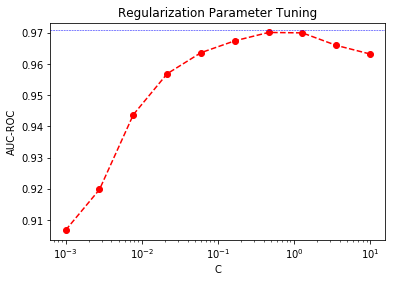

In [66]:
plt.plot(Cs, scores, 'ro--')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
# horizontal line -- model quality with default C value
plt.axhline(y=get_auc_lr_valid(X_train_strt_mnth_hr_morning_s_poly, y_train), linewidth=.5, color = 'b', linestyle='dashed') 
plt.show()

In [67]:
pd.DataFrame({'C':Cs, "Score":scores}).sort_values(by='Score', ascending = False)

,C,Score
6,0.464159,0.970131
7,1.291550,0.969987
5,0.166810,0.967439
8,3.593814,0.965992
4,0.059948,0.963641
9,10.000000,0.963226
3,0.021544,0.956884
2,0.007743,0.943763
1,0.002783,0.919796
0,0.001000,0.906771


### Using CV to regularize

In [ ]:
# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# c_values = np.logspace(-2, 3, 100)

# X_train1 = X_train_strt_mnth_hr__morning_isday_s

# logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
# logit_searcher.fit(X_train1, y_train)

In [ ]:
# logit_searcher.C_

In [ ]:
# plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
# plt.xlabel('C')
# plt.ylabel('Mean CV-accuracy');

Make prediction for the test set and form a submission file.

In [35]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [68]:
C = 0.464159
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_hour']])
X_train1 = X_train_strt_mnth_hr_morning_s_poly

X_test1 = csr_matrix(hstack([full_sites_merged_tfid[idx_split:,:], 
                            strt_mnth_hr_morning_s_poly[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C, random_state=17).fit(X_train1, y_train)

# Make a prediction for the test set
test_pred = lr.predict_proba(X_test1)[:, 1]

# Write it to the submission file
write_to_submission_file(test_pred, 'assignment6_alice_submission13.csv')